# <font color="blue">Text Detection using EAST</font>
In this notebook, we will go over the EAST Text Detector. We will use OpenCV to load the model and perform detections.

In [1]:
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install keras-ocr > /dev/null // If on UNXI- like systems
!pip install keras-ocr
from keras_ocr.tools import warpBox

     ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
     ---------------------------------------- 42.3/42.3 kB 2.0 MB/s eta 0:00:00
  Using cached validators-0.22.0-py3-none-any.whl (26 kB)
     ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
      --------------------------------------- 0.2/9.5 MB 4.6 MB/s eta 0:00:03
     -- ------------------------------------- 0.5/9.5 MB 5.4 MB/s eta 0:00:02
     ---- ----------------------------------- 1.1/9.5 MB 7.6 MB/s eta 0:00:02
     ---- ----------------------------------- 1.1/9.5 MB 8.0 MB/s eta 0:00:02
     ----- ---------------------------------- 1.2/9.5 MB 5.1 MB/s eta 0:00:02
     ------- -------------------------------- 1.9/9.5 MB 6.6 MB/s eta 0:00:02
     -------- ------------------------------- 2.0/9.5 MB 6.1 MB/s eta 0:00:02
     -------- ------------------------------- 2.0/9.5 MB 6.1 MB/s eta 0:00:02
     ---------- ----------------------------- 2.6/9.5 MB 6.0 MB/s eta 0:00:02
     ----------- 

## <font color="blue">1. Download EAST model </font>

In [5]:
# !wget https://www.dropbox.com/s/axmr969oaz2km3e/frozen_east_text_detection.tar.gz?dl=0 -O frozen_east_text_detection.tar.gz --quiet
!curl -o https://www.dropbox.com/s/axmr969oaz2km3e/frozen_east_text_detection.tar.gz?dl=0 frozen_east_text_detection.tar.gz 
# !tar -xvzf frozen_east_text_detection.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: frozen_east_text_detection.tar.gz


In [6]:
!powershell -command "& { Invoke-WebRequest -Uri 'https://www.dropbox.com/s/axmr969oaz2km3e/frozen_east_text_detection.tar.gz?dl=1' -OutFile 'frozen_east_text_detection.tar.gz' }"


In [7]:
import tarfile

# Open the tar.gz file
with tarfile.open('frozen_east_text_detection.tar.gz', 'r:gz') as tar:
    # Extract all files
    tar.extractall()

# <font color="blue">2. Specify parameters for detection</font>

There are two outputs of the network. One specifies the geometry of the Text-box and the other specifies the confidence score of the detected box. These are given by the layers :

- feature_fusion/concat_3
- feature_fusion/Conv_7/Sigmoid

We will add them to a list and pass this list to the network while generating the output so that the code knows which nodes to evaluate.

Apart from this, we need to specify the network input size and thresholds for detection.

In [17]:
model = "frozen_east_text_detection.pb"
net = cv2.dnn.readNet(model)
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")
inpWidth = 640
inpHeight = 640
confThreshold = 0.7
nmsThreshold = 0.4
#NMS (Non-Maximum Suppression) is a technique used in computer vision, particularly in object detection, to filter out redundant bounding boxes and keep only the most relevant ones. The NMS threshold is a parameter that determines how much overlap between two bounding boxes is acceptable before one of them is suppressed.
# In general, the NMS threshold is a value between 0 and 1. A higher threshold means that less overlap is allowed, resulting in fewer bounding boxes being retained. Conversely, a lower threshold allows more overlap, potentially keeping more bounding boxes.

# <font color="blue">3. Utility function for getting Rotated Rectangles</font>
The output of the network is in the form of rotated rectangles. Strangely,OpenCV has a function for NMS on rotated rectangles but no function to generate rotated rectangles in Python. This function takes in the bounding boxes from the network output and creates rotated rectangles which can be fed to the NMS function.

In [8]:
############ Utility functions ############
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

What is a blob?

blob" (binary large object) refers to a group of connected pixels that share some common property, such as color or intensity. Blobs are often used to represent and analyze regions or objects in an image

lobs can represent objects of interest in an image.
blobs can be detected using contours in a binary image. The contours represent connected regions of pixels with the same intensity.

So are blobs compressed way of represting  an image?
ChatGPT:
No, blobs in the context of computer vision are not a compressed representation of an image. Instead, they are used for segmenting and representing distinct regions or objects within an image based on certain properties, such as color, intensity, or texture.

Blob analysis involves identifying and analyzing connected components in an image. It's a technique for grouping pixels that share similar characteristics into meaningful regions. These regions (blobs) can then be analyzed further to extract features, detect objects, or perform other tasks.

# <font color="blue">4. Perform Text Detection</font>
For performing detection, we need to pass the image through the network and decode the output.

First, we need to create a 4-D input blob for feeding the image to the network. This is done using the **`blobFromImage`** function.

There are a few parameters we need to specify to this function. They are as follows :

1. The first argument is the image itself
1. The second argument specifies the scaling of each pixel value. In this case, it is not required. Thus we keep it as 1.
1. The default input to the network is `320×320`. So, we need to specify this while creating the blob. We will use `640x640`.
1. We also specify the mean that should be subtracted from each image since this was used while training the model. The mean used is (123.68, 116.78, 103.94).
1. The next argument is whether we want to swap the R and B channels. This is required since OpenCV uses BGR format and Tensorflow uses RGB format.
1. The last argument is whether we want to crop the image and take the center crop. We specify False in this case.

Once we have the output of the network, we need to use the decode function to decode the positions of the text boxes along with their orientation. We might get many candidates for a text box. Thus, we need to filter out the best looking text-boxes from the lot. This is done using Non-Maximum Suppression

Finally, we warp the boxes to fit into a rectangle so that the text is aligned. This is done using the warpBox function available in the keras-ocr package ( we will discuss more on this later ).

While subtracting mean from its image for Depp learning models which is better ,
subtracting the mean rgb values for that particular image, subtracting mean RGB values of batch or subtracting mean RGB values of entire dataset?
ChatGPT
When subtracting the mean from images for deep learning models, the choice of mean subtraction can depend on the specific use case and the available resources. Here are some considerations for each approach:

Subtracting the Mean of Each Image:

Pros: This approach is straightforward and doesn't require additional computation.
Cons: It may not be as effective if there is a lot of variation in the images within the dataset. Each image's mean might not represent the overall distribution of images.
Subtracting the Mean of the Batch:

Pros: Takes into account the mean of the current batch of images, providing a more adaptive normalization.
Cons: It may not be as stable if the batch size is small, and it can introduce variability between batches.
Subtracting the Mean of the Entire Dataset:

Pros: Provides a more global normalization, capturing the overall distribution of the dataset.
Cons: Requires calculating the mean over the entire dataset before training, which might be impractical for large datasets.
The choice often depends on the size of the dataset, the computational resources available, and the characteristics of the dataset. In practice, subtracting the mean of each image or batch is commonly used, especially when dealing with large datasets, as it allows for online training without precomputing statistics for the entire dataset.

Additionally, for modern deep learning models and tasks, batch normalization layers are frequently employed, which can reduce the sensitivity to mean subtraction. Batch normalization normalizes activations by the mean and standard deviation of the current mini-batch during training. This allows the model to adapt to different means and variances without manual adjustment.

In [10]:
def eastTextDetection(imageName, saveCrops = False):
  
  image = cv2.imread(imageName)
  imageOut = image.copy()
  # Get Height and width of the image.
  height_ = image.shape[0]
  width_ = image.shape[1]
  
  # Get ratio by which the image is resized for using in the network
  rW = width_ / float(inpWidth)
  rH = height_ / float(inpHeight)

  # Create a blob and assign the image to the blob
  #Subtracting the mean of entire dataset best -> it provides more normalization
  blob = cv2.dnn.blobFromImage(image, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False) #We can caluclate the mean for the given image and subtract it too(a diff approach).
  net.setInput(blob)

  # Get the output using by passing the image through the network
  output = net.forward(outputLayers)
  scores = output[0]
  geometry = output[1]

  # Get rotated rectangles using the decode function described above
  [boxes, confidences] = decode(scores, geometry, confThreshold)  
  indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold,nmsThreshold)

  cropped_warped_all = []
  for i,idx in enumerate(indices):
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[idx])

    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
      vertices[j][0] *= rW
      vertices[j][1] *= rH
    
    pts = np.array(vertices,dtype=int)

    # Align the cropped boxes using perspective transform
    cropped_warped = warpBox(image, pts)
    cropped_warped_all.append(cropped_warped)
    
    # Save cropped text boxes if required
    if saveCrops:
      cv2.imwrite("crop{}_{}".format(i,imageName), cropped_warped)
    
    # Annotate the boxes on the image
    for j in range(4):
      p1 = (vertices[j][0], vertices[j][1])
      p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
      cv2.line(imageOut, (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (0, 255, 0), 2, cv2.LINE_AA)
    
  return imageOut, cropped_warped_all

# <font color="blue">5. Download Images</font>

In [ ]:
# !wget https://www.dropbox.com/s/xz24vxrp4uvvnri/license_plate.jpg?dl=0 -O demo1.jpg --quiet
# !wget https://www.dropbox.com/s/uwlnxiihqgni57o/streetsign1.jpg?dl=0 -O demo2.jpg --quiet
# !wget https://www.dropbox.com/s/dbkag5gsicxqoqg/streetsign2.jpg?dl=0 -O demo3.jpg --quiet

In [12]:
!powershell -command "& { Invoke-WebRequest 'https://www.dropbox.com/s/xz24vxrp4uvvnri/license_plate.jpg?dl=0' -OutFile 'demo1.jpg'}" 
!powershell -command "& { Invoke-WebRequest 'https://www.dropbox.com/s/uwlnxiihqgni57o/streetsign1.jpg?dl=0' -OutFile 'demo2.jpg'}"
!powershell -command "& { Invoke-WebRequest 'https://www.dropbox.com/s/dbkag5gsicxqoqg/streetsign2.jpg?dl=0' -OutFile 'demo3.jpg'}"

Get all images starting with demo and create a list. We will perform detection on this list of images.

In [15]:
imageNames = glob.glob("demo*.jpg")
print(imageNames)

['demo1.jpg', 'demo2.jpg', 'demo3.jpg']


# <font color="blue">6. Display Outputs</font>
We will display the annotated output image as well as 4 cropped images.

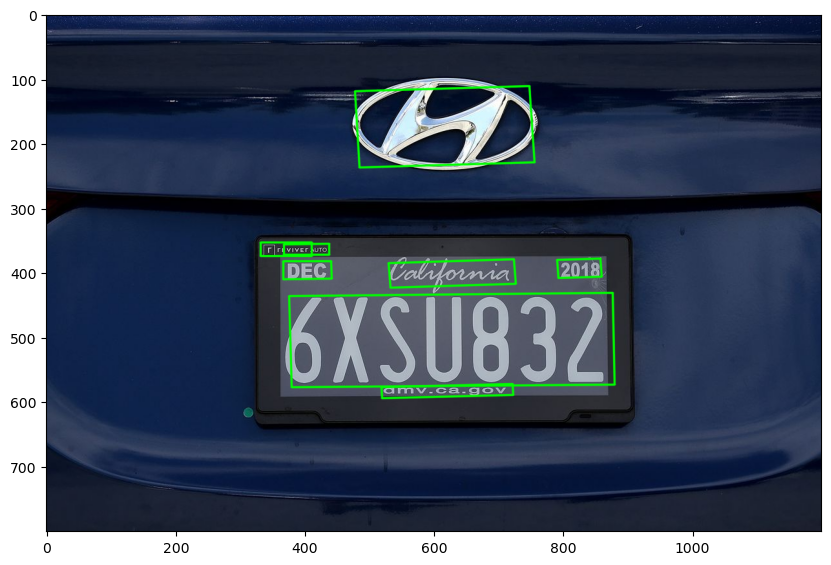

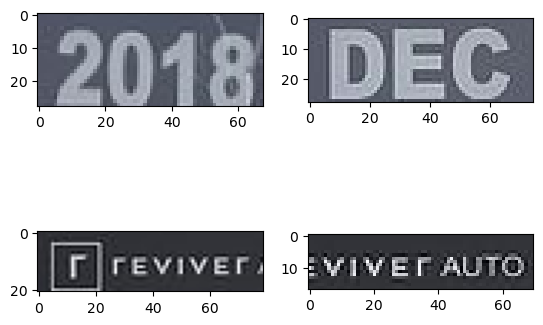

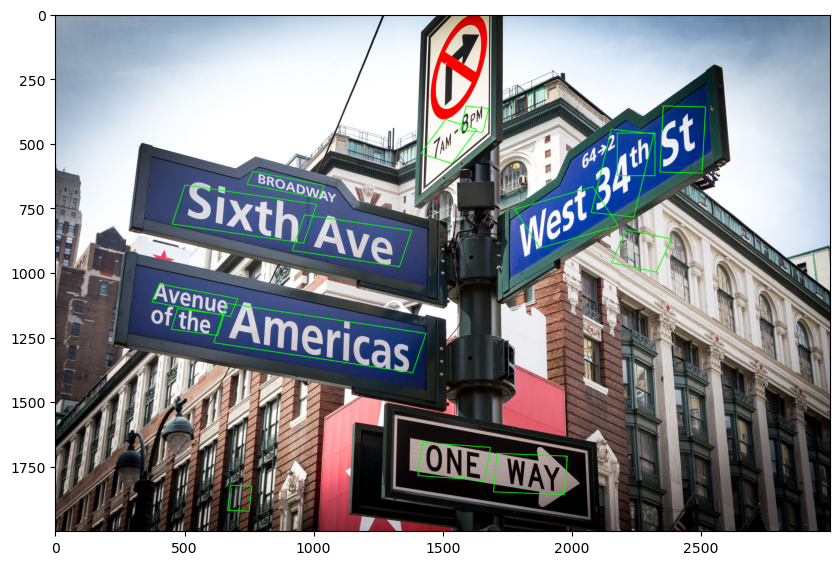

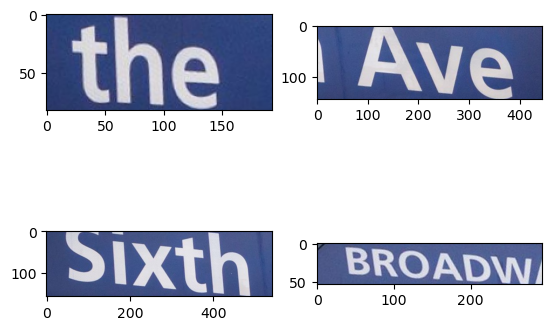

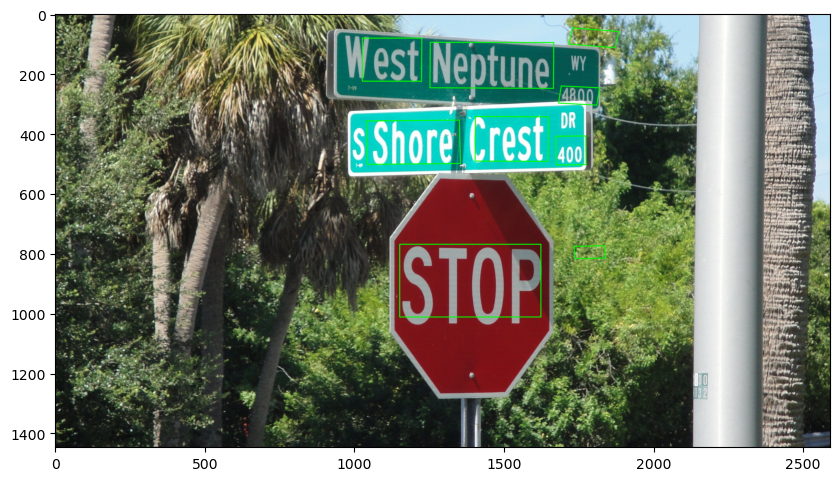

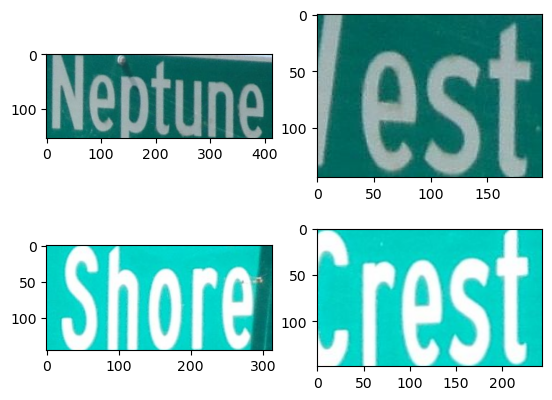

In [18]:
# Plot the predictions
for imageName in imageNames:
  imgOut,warped = eastTextDetection(imageName,saveCrops=True)
  plt.figure(figsize=[10,10])
  plt.imshow(imgOut[:,:,::-1])
  plt.show()
  for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(warped[i][:,:,::-1])
  plt.show()

It makes a few mistakes in some cases. We will learn about a more robust algorithm called **`CRAFT`** in the next notebook.